In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [2]:
# TensorFlow and tf.keras
# import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import urllib3

# import tensorflow_datasets as tfds

# Input Normalization

In [6]:
# def normalize_and_resize_img(image, label):
#     """Normalizes images: `uint8` -> `float32`."""
#     # image = tf.image.resize(image, [32, 32])
#     return tf.cast(image, tf.float32) / 255., label

In [7]:
# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=1
#     )
#     ds = ds.batch(batch_size)
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

# VGG Basic Block

In [3]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    x = input_layer

    # CNN layer
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling layer
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [4]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3)) 
vgg_block_output = build_vgg_block(vgg_input_layer)

In [5]:
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


# VGG-16

In [15]:
def build_vgg(input_shape=(256,256,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) # confirm config list size same
    
    input_layer = keras.layers.Input(shape=input_shape)  # MAKE input layer
    output = input_layer
    
    # MAKE block for config list size
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [16]:
vgg_16 = build_vgg()

vgg_16.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)        

In [17]:
# BATCH_SIZE = 256
# EPOCH = 20

# checkpoint_dir = './Models/'

In [19]:
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
#                                                 save_weights_only=True,
#                                                 monitor='val_loss',
#                                                 mode='auto',
#                                                 save_best_only=True,
#                                                 verbose=1)

In [ ]:
# # history for acc and loss graph
# import matplotlib.pyplot as plt

# acc = history_16.history['accuracy']
# val_acc = history_16.history['val_accuracy']

# loss = history_16.history['loss']
# val_loss = history_16.history['val_loss']

# epochs_range = range(len(acc))

# plt.figure(figsize=(8, 8))
# plt.subplot(2, 1, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# # plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# # plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
# vgg_16.save('./Models/vgg16_model_e20.h5')

# VGG-19

In [ ]:
# vgg_19 = build_vgg(
#     num_cnn_list=[2,2,4,4,4],
#     channel_list=[64,128,256,512,512]
# )

# vgg_19.summary()

# Apply Deepfake Dataset

### make dataset

In [8]:
import os
data_path = os.getenv('HOME') + '/project/dacon/crop_face_mini'

print(data_path)

/home/ubuntu/project/dacon/crop_face_WOfsgan


In [9]:
image_size = (256, 256)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    batch_size=batch_size, 
    image_size=image_size, 
    shuffle=True, 
    seed=1337, 
    validation_split=0.2,
    subset='training',
    interpolation='bilinear', 
    follow_links=False
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, 
    batch_size=batch_size, 
    image_size=image_size, 
    shuffle=True, 
    seed=1337, 
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear', 
    follow_links=False
)

Found 1418621 files belonging to 2 classes.
Using 1134897 files for training.
Found 1418621 files belonging to 2 classes.
Using 283724 files for validation.


In [10]:
train_ds.map

<bound method DatasetV2.map of <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>>

In [11]:
val_ds.map

<bound method DatasetV2.map of <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>>

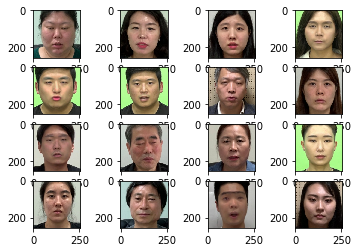

In [12]:
for img, label in train_ds.take(1):
    for i in range(4):
        for j in range(4):            
            plt.subplot(4, 4, i*4 + j + 1)
            plt.imshow(img[i*4 + j].numpy().astype(np.uint8))

In [13]:
print(label) # maybe 0 is fake, 1 is real

tf.Tensor(
[1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1], shape=(64,), dtype=int32)


In [16]:
# vgg-19 for Deepfake Detection
vgg_19_forDD = build_vgg(
    input_shape=(256, 256, 3),
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19_forDD.summary()

ResourceExhaustedError: OOM when allocating tensor with shape[32768,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [28]:
# print(len(train_ds))
# print(len(val_ds))

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCH = 5
checkpoint_dir = './Models/'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('./Models/best_at_{epoch}.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [30]:
vgg_19_forDD.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19_forDD = vgg_19_forDD.fit(
    train_ds,
    # steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    # validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=val_ds,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[es, mc]
)

17733/17733 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9854WARNING:tensorflow:Can save best model only with val_acc available, skipping.


17733/17733 [==============================] - 9636s 543ms/step - loss: 0.1809 - accuracy: 0.9854 - val_loss: 0.0040 - val_accuracy: 0.9987


In [31]:
### model save
vgg_19_forDD.save('./Models/vgg_DD_only1epoch.h5')

In [ ]:
# history for acc and loss graph (VGG-19)

acc = history_19_forDD.history['accuracy']
val_acc = history_19_forDD.history['val_accuracy']

loss = history_19_forDD.history['loss']
val_loss = history_19_forDD.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# apply real dataset

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
# dataGenerator = ImageDataGenerator(rescale=1./255)
dataGenerator = ImageDataGenerator(rescale=1)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7104 images belonging to 2 classes.


Predicted likelihood: 0.2065
Actual label: 1

Correct prediction: False


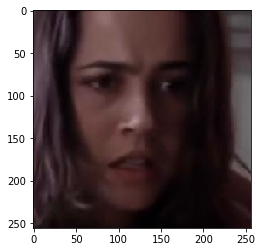

In [34]:
# Rendering image X with label y for VGG
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {vgg_19_forDD.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(vgg_19_forDD.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X.astype(int)));

# print(X)

In [35]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [36]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = vgg_19_forDD.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

0  predictions completed.
1000  predictions completed.
2000  predictions completed.
3000  predictions completed.
4000  predictions completed.
5000  predictions completed.
6000  predictions completed.
7000  predictions completed.
All 7104 predictions completed


In [37]:
print(len(correct_deepfake))
print(len(correct_deepfake_pred))

89
89


In [38]:
print(len(correct_real))
print(len(correct_real_pred))

3472
3472


In [43]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j].astype(int)))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

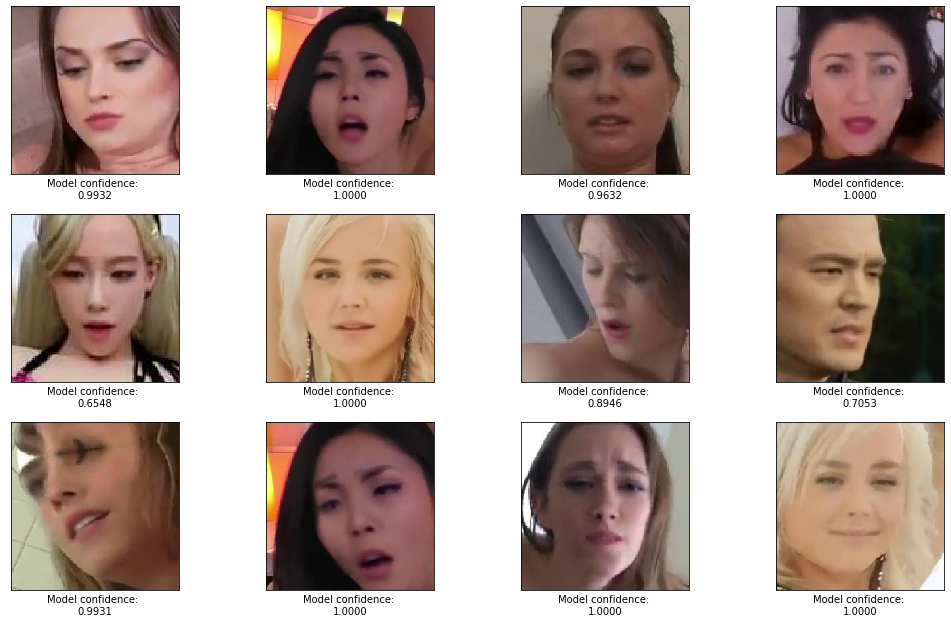

In [44]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)

correct_real
correct_deepfake
misclassified_real
misclassified_deepfake

In [39]:
print("acc :",(len(correct_real) + len(correct_deepfake)) / (len(correct_real) + len(correct_deepfake) + len(misclassified_real) + len(misclassified_deepfake)))

acc : 0.5012668918918919


In [40]:
print((len(misclassified_real) + len(misclassified_deepfake)) / (len(correct_real) + len(correct_deepfake) + len(misclassified_real) + len(misclassified_deepfake)))

0.4987331081081081
